In [1]:
# Working environment informations;

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


Mon Jun 26 19:45:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Dataset preparation

!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jctsfj2sfn-1.zip
!unzip jctsfj2sfn-1.zip
!unzip covid19-pneumonia-normal-chest-xraypa-dataset.zip
!pip install split-folders

import splitfolders
# Split with a ratio.
# To only split into training and test set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/working/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/", output="/kaggle/working/output", seed=1903, ratio=(.8, .2)) # default values

--2023-06-26 19:46:12--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jctsfj2sfn-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.69.108, 52.218.21.11, 52.218.24.35, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.69.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1437762638 (1.3G) [application/octet-stream]
Saving to: ‘jctsfj2sfn-1.zip’

jctsfj2sfn-1.zip    100%[===================>]   1.34G  31.5MB/s    in 47s     

2023-06-26 19:46:59 (29.2 MB/s) - ‘jctsfj2sfn-1.zip’ saved [1437762638/1437762638]

Archive:  jctsfj2sfn-1.zip
  inflating: covid19-pneumonia-normal-chest-xraypa-dataset.zip  
Archive:  covid19-pneumonia-normal-chest-xraypa-dataset.zip
  inflating: COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/01E392EE-69F9-4E33-BFCE-E5C9686

Copying files: 4575 files [00:02, 1731.26 files/s]


Importing Libraries

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D, 
    Dropout, Input, Concatenate, GlobalAveragePooling2D, Reshape, Multiply
)
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import (
    imagenet_utils, DenseNet121, VGG16, VGG19, MobileNet, MobileNetV2, Xception, EfficientNetB3
)
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.regularizers import l2

Image Preprocessing Part

In [19]:
from keras.preprocessing.image import ImageDataGenerator

img_rows = 128
img_cols = 128
batch_size = 32

train_dataset = '/kaggle/working/output/train'
test_dataset = '/kaggle/working/output/val'

validation_split = 0.2
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=validation_split,
                                    rotation_range = 20,  # randomly rotate images in the range (degrees, 0 to 180)
                                    vertical_flip=False)  # randomly flip images

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_dataset,
                                                    target_size = (img_rows, img_cols),
                                                    batch_size = batch_size,
                                                    #color_mode = 'grayscale',
                                                    seed = 1903,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dataset,
                                                    target_size = (img_rows, img_cols),
                                                    batch_size = batch_size,
                                                    #color_mode = 'grayscale',
                                                    seed = 1903,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    subset='validation')

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                  target_size = (img_rows, img_cols),
                                                  batch_size = batch_size,
                                                  #color_mode = 'grayscale',
                                                  shuffle = False, class_mode='categorical')

steps_per_epoch = (train_generator.samples) // batch_size
label_names = list(train_generator.class_indices.keys())

print("\nNumber of Training samples   : "\
      ,train_generator.samples+validation_generator.samples,\
      "(",train_generator.samples,"train +",validation_generator.samples,"validation)")
print("Number of Test samples : ", test_generator.samples)
print("\nLabel names: ",label_names)
print("\nSteps per epoch: ", steps_per_epoch)

Found 2928 images belonging to 3 classes.
Found 732 images belonging to 3 classes.
Found 915 images belonging to 3 classes.

Number of Training samples   :  3660 ( 2928 train + 732 validation)
Number of Test samples :  915

Label names:  ['covid', 'normal', 'pneumonia']

Steps per epoch:  91


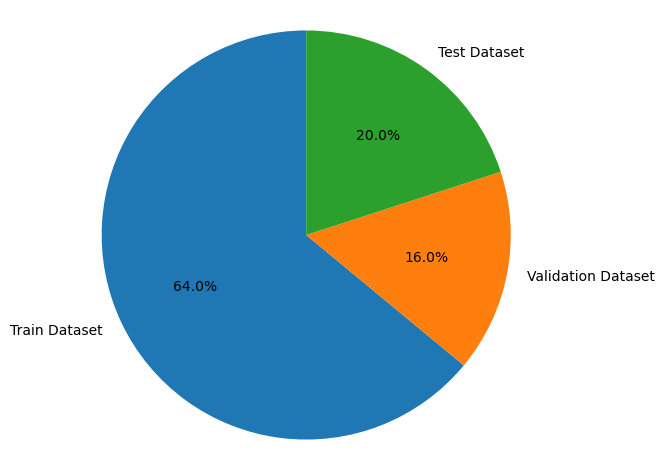

In [20]:
import matplotlib.pyplot as plt

# Data
train_dataset = 2928
val_dataset = 732
test_dataset = 915

labels = ['Train Dataset', 'Validation Dataset', 'Test Dataset']
sizes = [train_dataset, val_dataset, test_dataset]

# Plot
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  

plt.tight_layout()
plt.show()

We resized them to be 128. We divided them into 32 batch sizes. We mirrored and gave rotation at the training stage. We divided the training dataset into two again: .8 training .2 validation.We trained the network using the data we prepared. In the validation part, we verified the network we trained. Finally, we tested the verified network.

MODEL 1 -- TRANSFER LEARNING WITH DENSENET

In [6]:
# Transfer learning with DenseNet

base_model=tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",input_shape=(img_rows,img_cols,3), pooling='max')
base_model.trainable = False

learning_rate = 1e-5
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
#x=Dropout(rate=.4, seed=123)(x)

output=Dense(3, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=output)

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization

In the Transfer learning with Densenet section, we took a trained model and added our own training on it. We used our own dataset for this and got the result of 92% with a low number of parameters.

In [7]:
#reduces learning rate if no significant decrease in loss for {{patience}} epochs.
RLROP = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1,min_lr=1e-8)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
)

csvlogger = CSVLogger(
    filename= "densenet_121.csv",
    separator = ",",
    append = False
)

#save best model
#path where highest valid accuracy will save
checkpoint_file = "densenet_121.hdf5"
#callback to save the best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose = 1,
    save_best_only=True)

#adam, binary_crossentropy, accuracy
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

If validation accuracy does not change 3 times, the learning rate drops to one in 10. So, for example, 10e^-5 would be 10e^-6.

The early stop code runs when validation accuracy does not increase for 5 epochs and stops network training.

CSV and logger keeps log of all work. Tensorboard is used when training the model.

The file with the .hdf5 extension is our trained network. Backed up for use in other studies.

In [8]:
history_densenet_121_2 = model.fit(
    train_generator, 
    validation_data  = validation_generator,
    epochs = 30, verbose = 1,
    callbacks = [RLROP, model_checkpoint_callback, csvlogger, tensorboard, early_stop]
)

Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 3.4526 - accuracy: 0.9109
Epoch 1: val_accuracy improved from -inf to 0.73634, saving model to densenet_121.hdf5
92/92 [==============================] - 76s 671ms/step - loss: 3.4526 - accuracy: 0.9109 - val_loss: 2.2828 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 0.8645 - accuracy: 0.9457
Epoch 2: val_accuracy improved from 0.73634 to 0.74180, saving model to densenet_121.hdf5
92/92 [==============================] - 57s 618ms/step - loss: 0.8645 - accuracy: 0.9457 - val_loss: 1.3071 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.9471
Epoch 3: val_accuracy improved from 0.74180 to 0.76366, saving model to densenet_121.hdf5
92/92 [==============================] - 56s 613ms/step - loss: 0.4678 - accuracy: 0.9471 - val_loss: 1.1414 - val_accuracy: 0.7637 - lr: 0.0010
Epoch 4/30
92/92

This part of our code is the training and validation part.
While training our code, we reached the maximum validation accuracy value (0.7814) in the 12th epoch. Our total number of epochs is 30, but it could continue until the 17th epoch because our early stop code was activated.

In [ ]:
#achieved local minima without overfitting.
#loading the best model
model.load_weights("/kaggle/working/densenet_121.hdf5")       #13th epoch model

Last Epoch:

Training Accuracy    : 0.9784836173057556
Training Loss        : 0.18746545910835266
Validation Accuracy  : 0.7745901346206665
Validation Loss      : 1.2969897985458374

All Epochs:


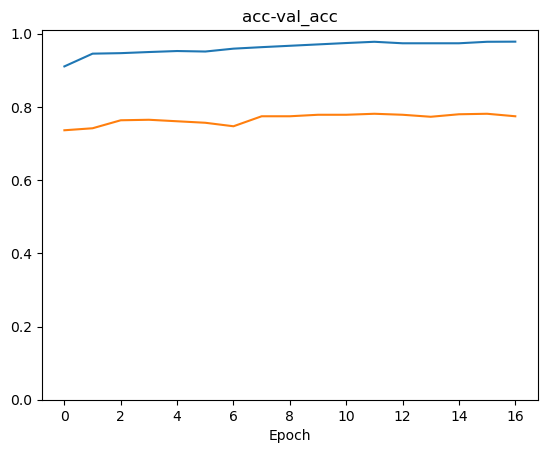

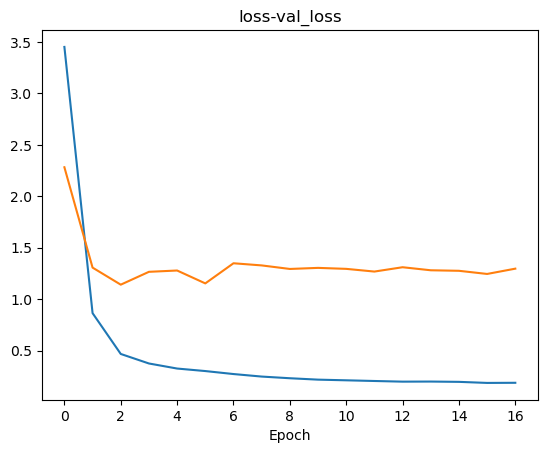



Classification Report

29/29 [==============================] - 14s 413ms/step
              precision    recall  f1-score   support

       covid     0.8943    0.9705    0.9308       305
      normal     0.8854    0.9115    0.8982       305
   pneumonia     1.0000    0.8852    0.9391       305

    accuracy                         0.9224       915
   macro avg     0.9265    0.9224    0.9227       915
weighted avg     0.9265    0.9224    0.9227       915


Confusion Matrix



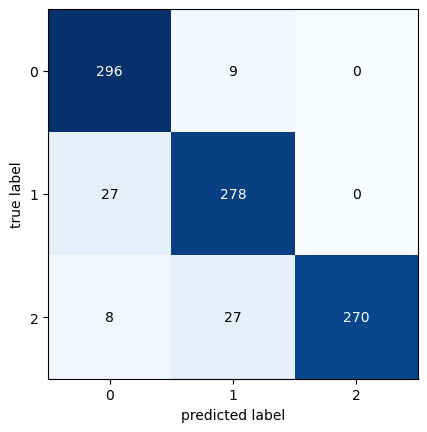

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

print("Last Epoch:\n")
model_accuracy_nas      = history_densenet_121_2.history['accuracy'][-1]
model_loss_nas          = history_densenet_121_2.history['loss'][-1]
model_val_accuracy_nas    = history_densenet_121_2.history['val_accuracy'][-1]
model_val_loss_nas        = history_densenet_121_2.history['val_loss'][-1]
print("Training Accuracy    :", model_accuracy_nas )
print("Training Loss        :", model_loss_nas)
print("Validation Accuracy  :", model_val_accuracy_nas )
print("Validation Loss      :", model_val_loss_nas)

print("\nAll Epochs:")
def plot_history_acc():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("acc-val_acc")
    plt.axis([None, None, 0, 1.01])
    plt.plot(history_densenet_121_2.history['accuracy'])
    plt.plot(history_densenet_121_2.history['val_accuracy'])
    plt.show()

def plot_history_loss():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("loss-val_loss")
    plt.axis([None, None, None, None])
    plt.plot(history_densenet_121_2.history['loss'])
    plt.plot(history_densenet_121_2.history['val_loss'])
    plt.show()

plot_history_acc()
plot_history_loss()

print("\n=============================================================================================\n")
print('Classification Report\n')
Y_pred_model = model.predict(test_generator, test_generator.samples // batch_size+1)
y_pred_model = np.argmax(Y_pred_model, axis=1)
class_rep_model = classification_report(test_generator.classes, y_pred_model, target_names=label_names, digits=4)
print(class_rep_model)

print('\nConfusion Matrix\n')
cm_plot_labels=['Covid','Normal','Pneumonia']
conf_matrix_model = confusion_matrix(test_generator.classes, y_pred_model)
cm_model = np.array2string(conf_matrix_model)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_model, classes=cm_plot_labels, title='Confusion matrix') #labels part added but not tested.
plt.show()

MODEL 2 -- CNN+DENSENET OUTPUT

In [12]:
modelBUN = tf.keras.Sequential([
    Conv2D(16, kernel_size=3, activation='relu', input_shape=(128,128,3), padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(128, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(256, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(512, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(1024, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(3, activation = "softmax")
])

In [14]:
#reduces learning rate if no significant decrease in loss for {{patience}} epochs.
RLROP = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1,min_lr=1e-8)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

tensorboard = TensorBoard(
    log_dir = './logs_bun',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
)

csvlogger = CSVLogger(
    filename= "bun_model.csv",
    separator = ",",
    append = False
)

#save best model
#path where highest valid accuracy will save
checkpoint_file = "bun_model.hdf5"
#callback to save the best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose = 1,
    save_best_only=True)

#adam, binary_crossentropy, accuracy
modelBUN.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
modelBUN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                        

In [15]:
history_bun = modelBUN.fit(
    train_generator, 
    validation_data  = validation_generator,
    epochs = 30, verbose = 1,
    callbacks = [RLROP, model_checkpoint_callback, csvlogger, tensorboard, early_stop]
)

Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.7920
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to bun_model.hdf5
92/92 [==============================] - 64s 608ms/step - loss: 0.6248 - accuracy: 0.7920 - val_loss: 5.5154 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8808
Epoch 2: val_accuracy improved from 0.33333 to 0.40301, saving model to bun_model.hdf5
92/92 [==============================] - 56s 607ms/step - loss: 0.3532 - accuracy: 0.8808 - val_loss: 1.2227 - val_accuracy: 0.4030 - lr: 0.0010
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.9102
Epoch 3: val_accuracy improved from 0.40301 to 0.53552, saving model to bun_model.hdf5
92/92 [==============================] - 55s 604ms/step - loss: 0.2605 - accuracy: 0.9102 - val_loss: 1.0155 - val_accuracy: 0.5355 - lr: 0.0010
Epoch 4/30
92/92 [=======

Our total epoch count is 30, but training stopped at the 25th epoch.Because in the 20th epoch, we reached the maximum validation accuracy value (0.7978).

Last Epoch:

Training Accuracy    : 0.994535505771637
Training Loss        : 0.0184347964823246
Validation Accuracy  : 0.7923497557640076
Validation Loss      : 4.315469264984131

All Epochs:


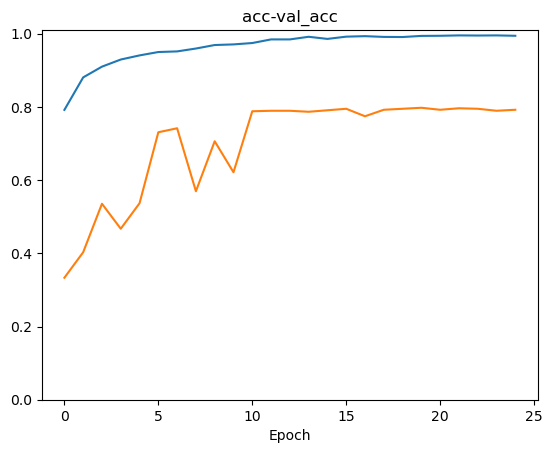

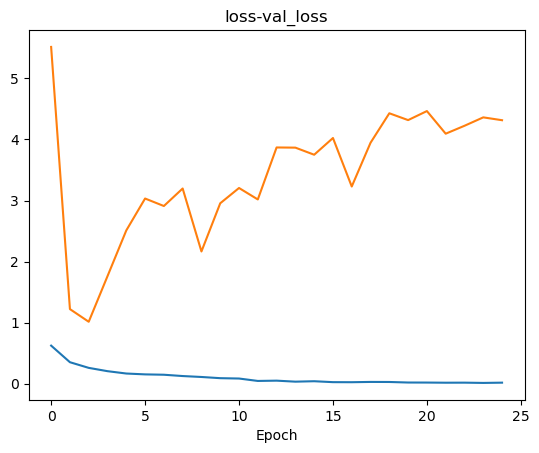



Classification Report

29/29 [==============================] - 10s 353ms/step
              precision    recall  f1-score   support

       covid     0.9231    0.9836    0.9524       305
      normal     0.9028    0.9443    0.9231       305
   pneumonia     0.9963    0.8852    0.9375       305

    accuracy                         0.9377       915
   macro avg     0.9407    0.9377    0.9377       915
weighted avg     0.9407    0.9377    0.9377       915


Confusion Matrix



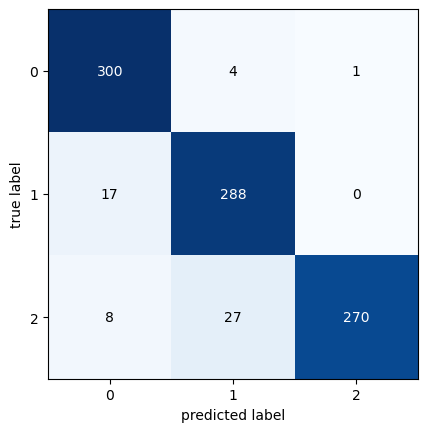

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

print("Last Epoch:\n")
model_accuracy_nas      = history_bun.history['accuracy'][-1]
model_loss_nas          = history_bun.history['loss'][-1]
model_val_accuracy_nas    = history_bun.history['val_accuracy'][-1]
model_val_loss_nas        = history_bun.history['val_loss'][-1]
print("Training Accuracy    :", model_accuracy_nas )
print("Training Loss        :", model_loss_nas)
print("Validation Accuracy  :", model_val_accuracy_nas )
print("Validation Loss      :", model_val_loss_nas)

print("\nAll Epochs:")
def plot_history_acc():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("acc-val_acc")
    plt.axis([None, None, 0, 1.01])
    plt.plot(history_bun.history['accuracy'])
    plt.plot(history_bun.history['val_accuracy'])
    plt.show()

def plot_history_loss():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("loss-val_loss")
    plt.axis([None, None, None, None])
    plt.plot(history_bun.history['loss'])
    plt.plot(history_bun.history['val_loss'])
    plt.show()

plot_history_acc()
plot_history_loss()

print("\n=============================================================================================\n")
print('Classification Report\n')
Y_pred_model = modelBUN.predict(test_generator, test_generator.samples // batch_size+1)
y_pred_model = np.argmax(Y_pred_model, axis=1)
class_rep_model = classification_report(test_generator.classes, y_pred_model, target_names=label_names, digits=4)
print(class_rep_model)

print('\nConfusion Matrix\n')
conf_matrix_model = confusion_matrix(test_generator.classes, y_pred_model)
cm_model = np.array2string(conf_matrix_model)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_model)
plt.show()


MODEL 3 -- BUNTT (CNN+SENet CUSTOM MADE BLOCK)

In [24]:
def se_block(inputs):
    channels = inputs.shape[-1]
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    excitation = Dense(channels // 16, activation='relu')(squeeze)
    excitation = Dense(channels, activation='sigmoid')(excitation)
    excitation = tf.keras.layers.Reshape((1, 1, channels))(excitation)
    scale = inputs * excitation
    return scale

inputs = tf.keras.Input(shape=(128, 128, 3))
x = Conv2D(16, kernel_size=3, activation='relu', padding="SAME", kernel_regularizer=l2(0.01))(inputs)
x = se_block(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(32, kernel_size=3, activation='relu', padding="SAME", kernel_regularizer=l2(0.01))(x)
x = se_block(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=3, activation='relu', padding="SAME", kernel_regularizer=l2(0.01))(x)
x = se_block(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=3, activation='relu', padding="SAME", kernel_regularizer=l2(0.01))(x)
x = se_block(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(256, kernel_size=3, activation='relu', padding="SAME", kernel_regularizer=l2(0.01))(x)
x = se_block(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(512, kernel_size=3, activation='relu', padding="SAME", kernel_regularizer=l2(0.01))(x)
x = se_block(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(1024, kernel_size=3, activation='relu', padding="SAME", kernel_regularizer=l2(0.01))(x)
x = se_block(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation="softmax")(x)

modelBUNTT = tf.keras.Model(inputs=inputs, outputs=outputs)
modelBUNTT.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d_14 (G  (None, 16)          0           ['conv2d_22[0][0]']              
 lobalAveragePooling2D)                                                                     

In [25]:
#reduces learning rate if no significant decrease in loss for {{patience}} epochs.
RLROP = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1,min_lr=1e-8)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

tensorboard = TensorBoard(
    log_dir = './logs_buntt',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
)

csvlogger = CSVLogger(
    filename= "buntt_model.csv",
    separator = ",",
    append = False
)

#save best model
#path where highest valid accuracy will save
checkpoint_file = "buntt_model.hdf5"
#callback to save the best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose = 1,
    save_best_only=True)

#adam, binary_crossentropy, accuracy
modelBUNTT.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
modelBUNTT.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d_14 (G  (None, 16)          0           ['conv2d_22[0][0]']              
 lobalAveragePooling2D)                                                                     

In [26]:
history_buntt = modelBUNTT.fit(
    train_generator, 
    validation_data  = validation_generator,
    epochs = 30, verbose = 1,
    callbacks = [RLROP, model_checkpoint_callback, csvlogger, tensorboard, early_stop]
)

Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 14.0983 - accuracy: 0.7883
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to buntt_model.hdf5
92/92 [==============================] - 69s 624ms/step - loss: 14.0983 - accuracy: 0.7883 - val_loss: 12.6813 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 7.6619 - accuracy: 0.8712
Epoch 2: val_accuracy did not improve from 0.33333
92/92 [==============================] - 55s 601ms/step - loss: 7.6619 - accuracy: 0.8712 - val_loss: 8.1738 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 4.4833 - accuracy: 0.8801
Epoch 3: val_accuracy did not improve from 0.33333
92/92 [==============================] - 55s 595ms/step - loss: 4.4833 - accuracy: 0.8801 - val_loss: 5.8397 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/30
92/92 [==============================] - ETA: 0s - loss: 2.9475 - accuracy: 0.891

Last Epoch:

Training Accuracy    : 0.9962431788444519
Training Loss        : 0.8335824608802795
Validation Accuracy  : 0.7978141903877258
Validation Loss      : 3.7450218200683594

All Epochs:


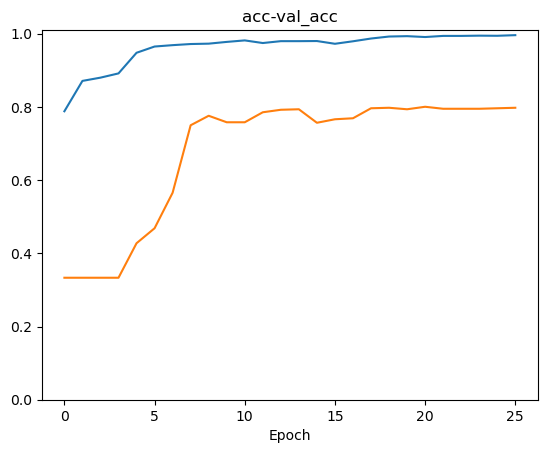

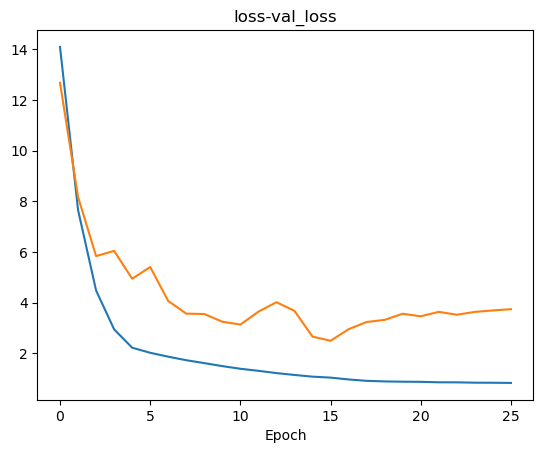



Classification Report

29/29 [==============================] - 11s 357ms/step
              precision    recall  f1-score   support

       covid     0.9429    0.9738    0.9581       305
      normal     0.8988    0.9607    0.9287       305
   pneumonia     0.9891    0.8885    0.9361       305

    accuracy                         0.9410       915
   macro avg     0.9436    0.9410    0.9409       915
weighted avg     0.9436    0.9410    0.9409       915


Confusion Matrix



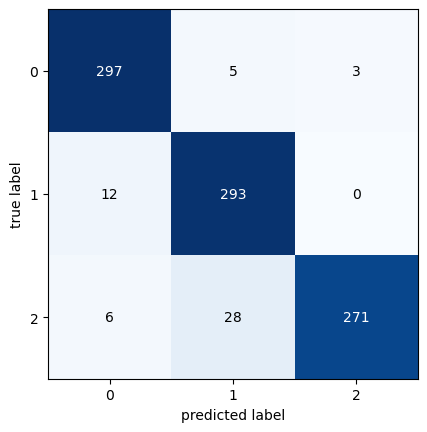

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

print("Last Epoch:\n")
model_accuracy_nas      = history_buntt.history['accuracy'][-1]
model_loss_nas          = history_buntt.history['loss'][-1]
model_val_accuracy_nas    = history_buntt.history['val_accuracy'][-1]
model_val_loss_nas        = history_buntt.history['val_loss'][-1]
print("Training Accuracy    :", model_accuracy_nas )
print("Training Loss        :", model_loss_nas)
print("Validation Accuracy  :", model_val_accuracy_nas )
print("Validation Loss      :", model_val_loss_nas)

print("\nAll Epochs:")
def plot_history_acc():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("acc-val_acc")
    plt.axis([None, None, 0, 1.01])
    plt.plot(history_buntt.history['accuracy'])
    plt.plot(history_buntt.history['val_accuracy'])
    plt.show()

def plot_history_loss():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("loss-val_loss")
    plt.axis([None, None, None, None])
    plt.plot(history_buntt.history['loss'])
    plt.plot(history_buntt.history['val_loss'])
    plt.show()

plot_history_acc()
plot_history_loss()

print("\n=============================================================================================\n")
print('Classification Report\n')
Y_pred_model = modelBUNTT.predict(test_generator, test_generator.samples // batch_size+1)
y_pred_model = np.argmax(Y_pred_model, axis=1)
class_rep_model = classification_report(test_generator.classes, y_pred_model, target_names=label_names, digits=4)
print(class_rep_model)

print('\nConfusion Matrix\n')
conf_matrix_model = confusion_matrix(test_generator.classes, y_pred_model)
cm_model = np.array2string(conf_matrix_model)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_model)
plt.show()


In [33]:
import shutil
shutil.make_archive("logs_densenet", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs_densenet.zip'

In [34]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 20.2 MB/s eta 0:00:0000:01


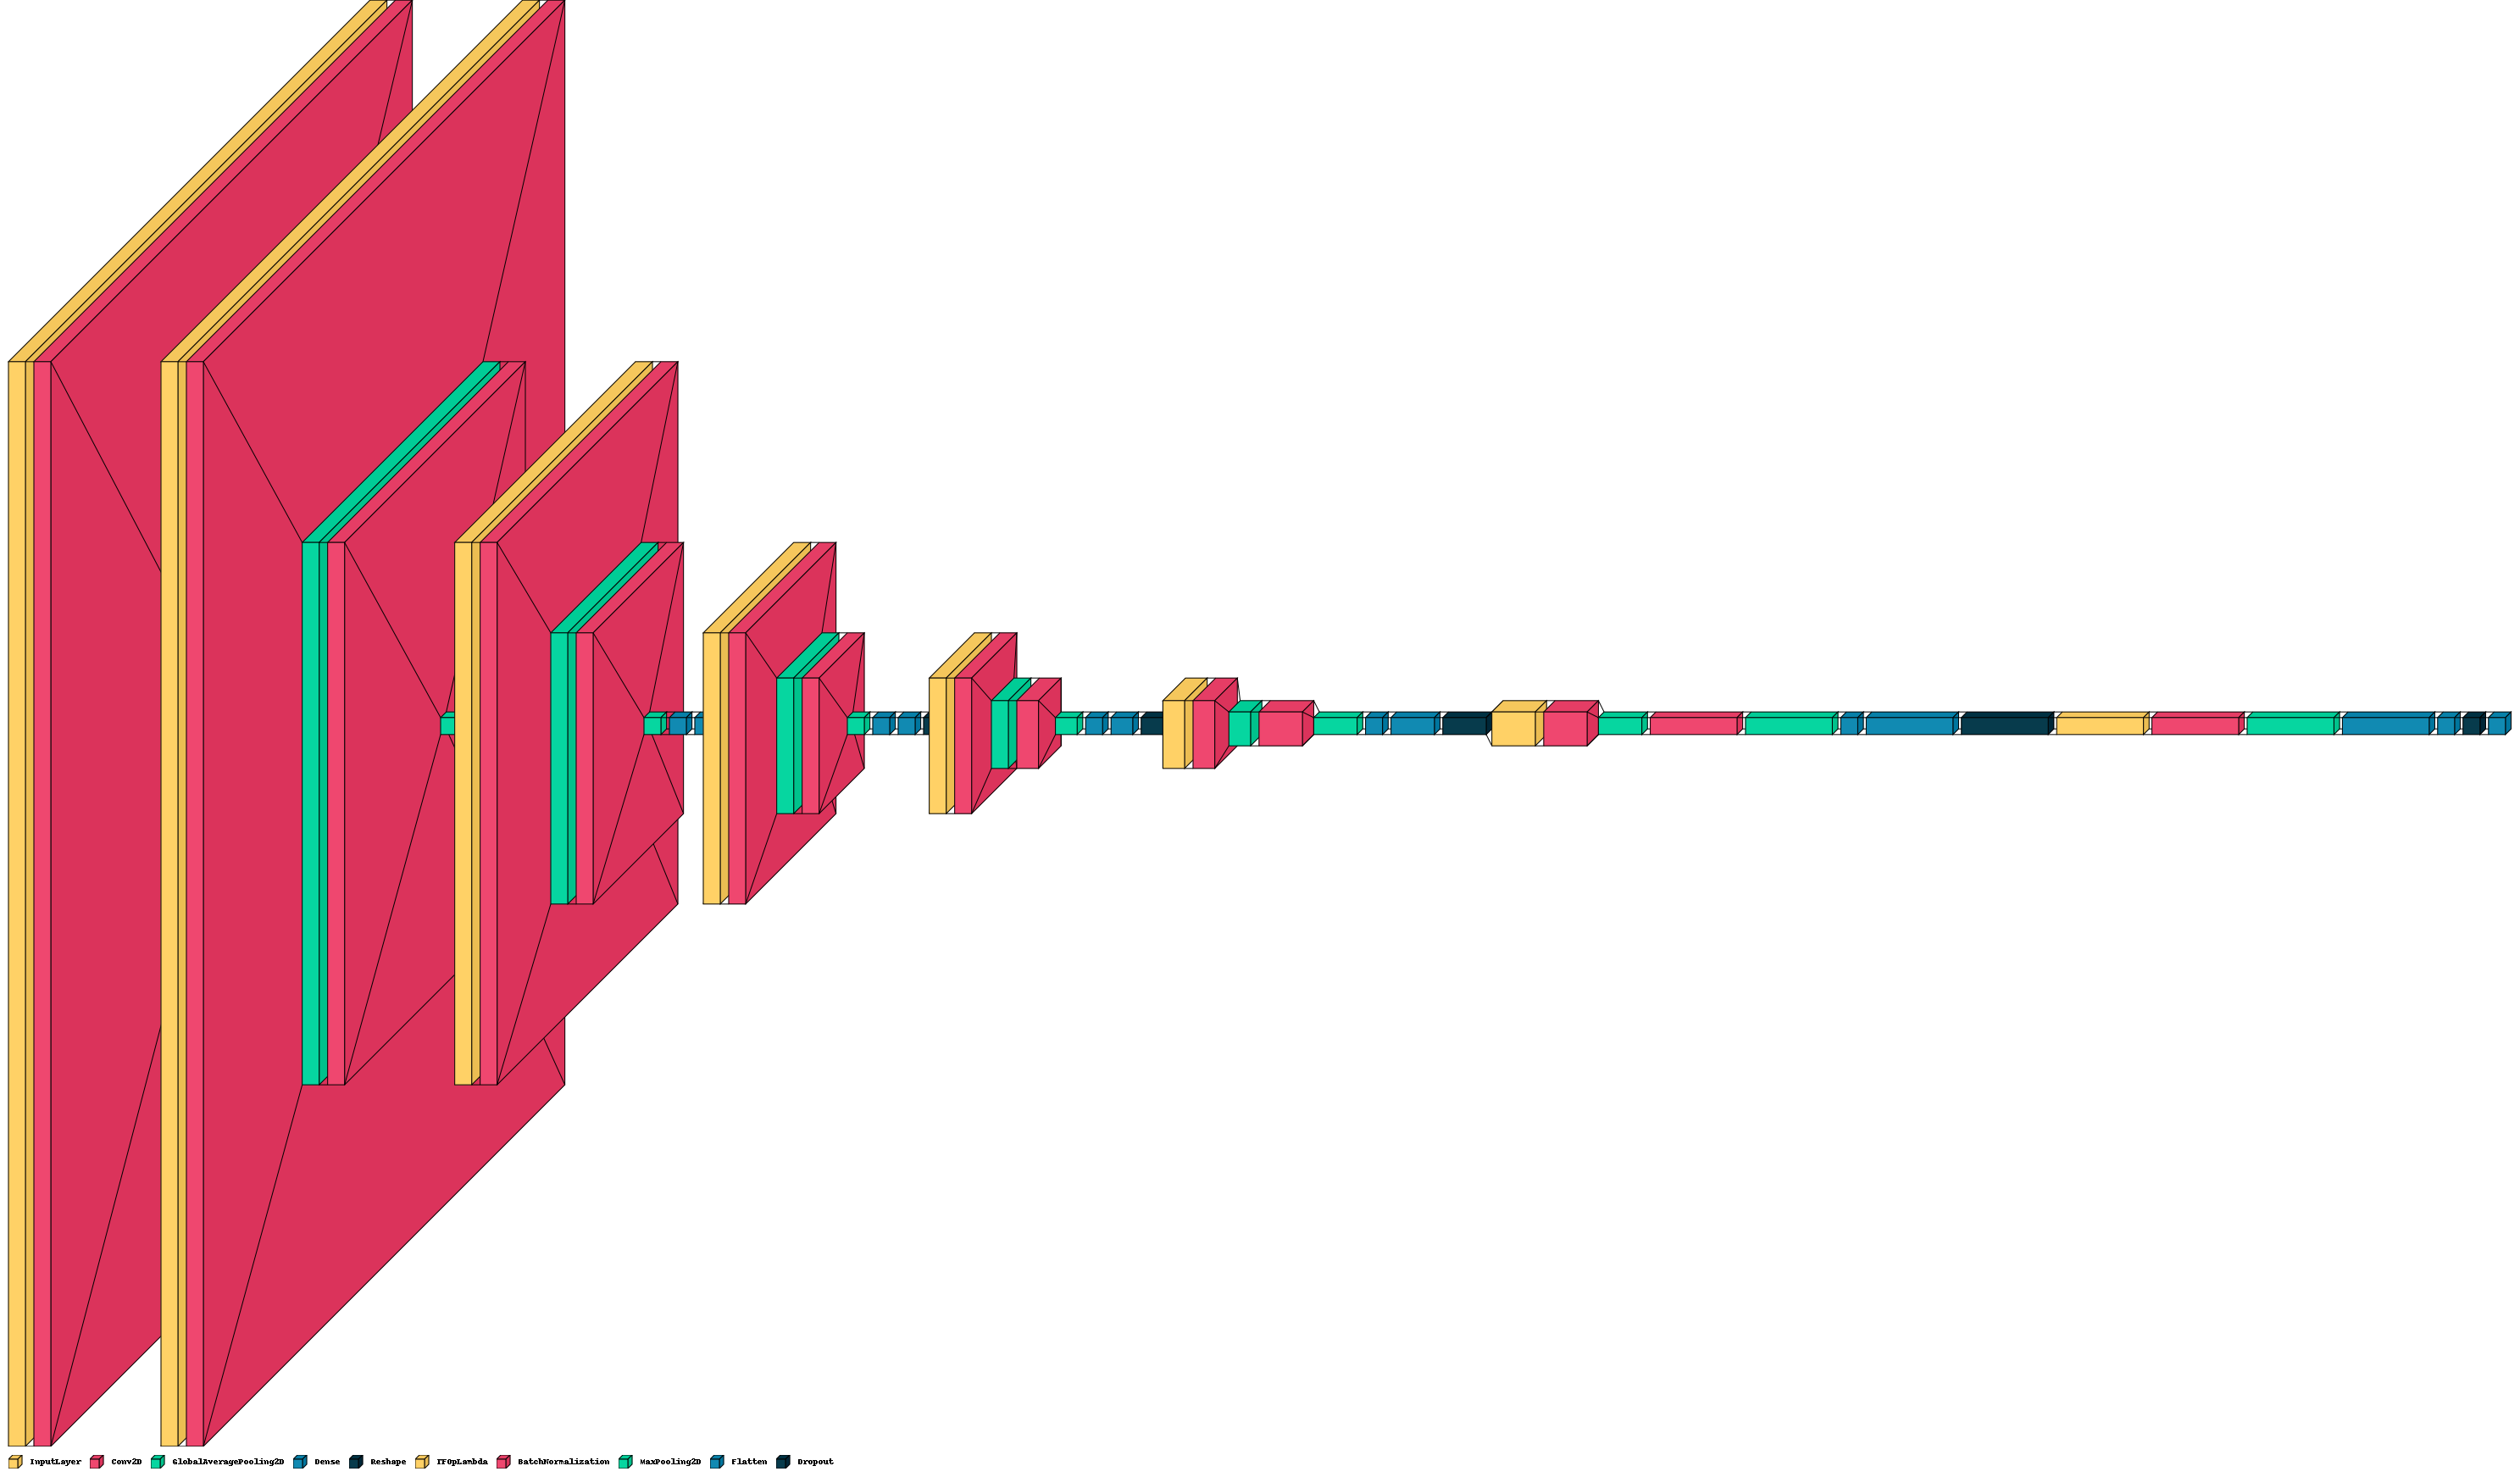

In [39]:
import visualkeras
visualkeras.layered_view(modelBUNTT, scale_xy=10, legend=True)

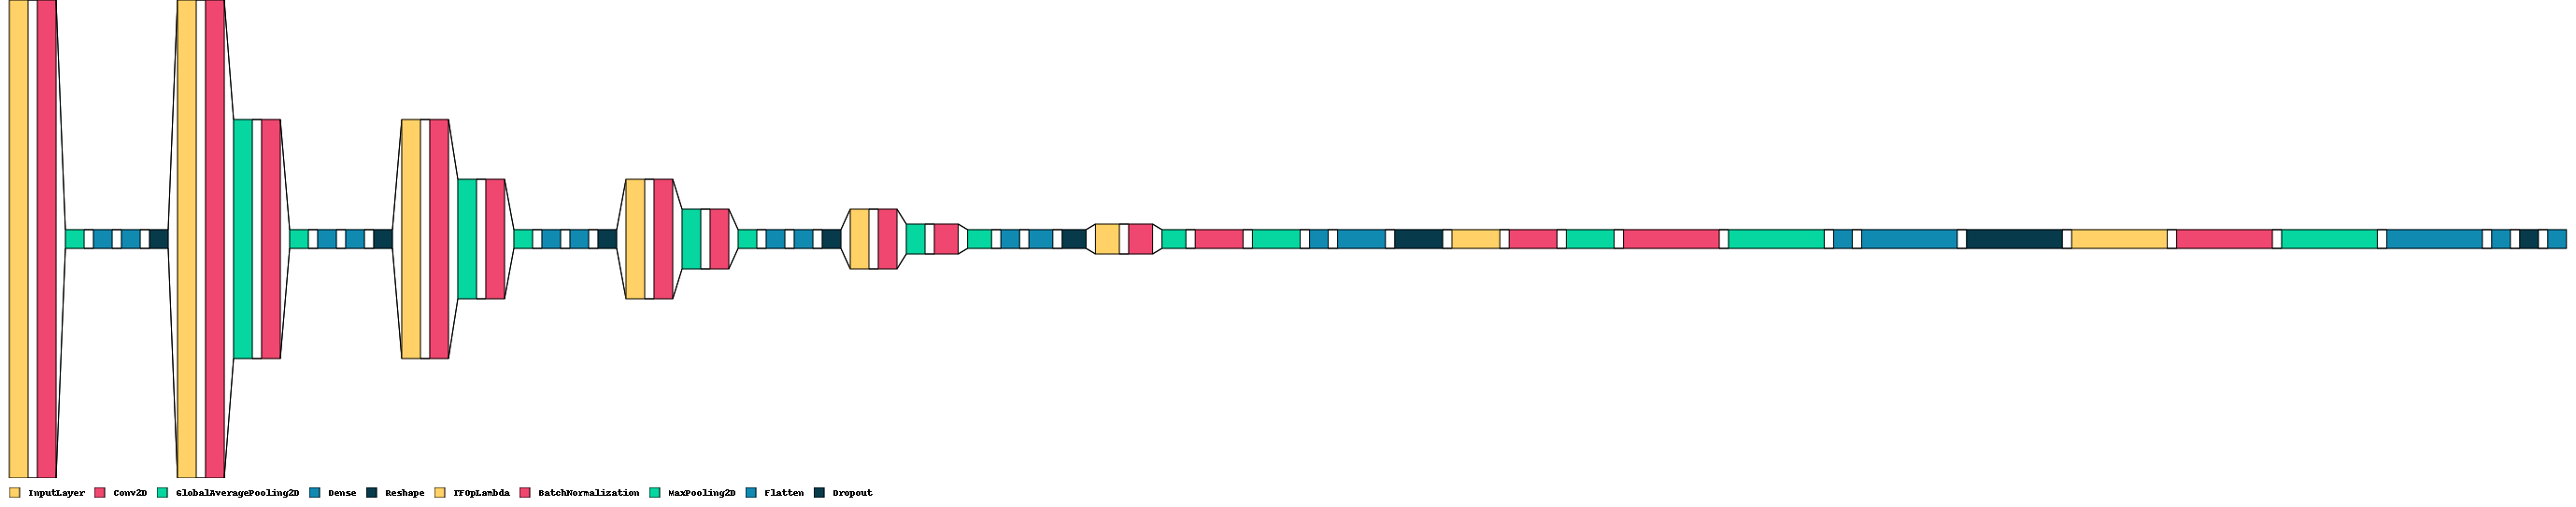

In [52]:
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D, InputLayer
from collections import defaultdict

color_map[InputLayer]['fill'] = 'magenta'
color_map[Conv2D]['fill'] = 'orange'
color_map[GlobalAveragePooling2D]['fill'] = 'gray'
color_map[BatchNormalization]['fill'] = 'cyan'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(modelBUNTT, draw_volume=False, legend=True)